In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Z5f9v0xDNmt3eu6JrN00")
project = rf.workspace("waleed-azzi-o5bzp").project("wildfire-detection-3vcvr")
version = project.version(3)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 114.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to wildfire-detection--3 in yolov8:: 100%|██████████| 33774/33774 [00:05<00:00, 6239.49it/s]


In [2]:
dataset.location

'/content/wildfire-detection--3'

2. Lire et comprendre data.yaml

In [3]:
import yaml

with open(dataset.location + "/data.yaml", "r") as f:
    data_yaml = yaml.safe_load(f)

print("Nom des classes :", data_yaml["names"])
print("Nombre de classes :", data_yaml["nc"])


Nom des classes : ['fire', 'smoke']
Nombre de classes : 2


In [4]:
import os

train_img_count = len(os.listdir(dataset.location + "/train/images"))
val_img_count = len(os.listdir(dataset.location + "/valid/images"))
print("Images entraînement :", train_img_count)
print("Images validation :", val_img_count)


Images entraînement : 15062
Images validation : 1215


##Redimensionner les images

In [5]:
import cv2
import os

def resize_images(folder_path, size=(640, 640)):
    count = 0
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                img = cv2.imread(image_path)
                if img is None:
                    print(f"Erreur de lecture: {image_path}")
                    continue
                resized = cv2.resize(img, size)
                cv2.imwrite(image_path, resized)
                count += 1
    print(f" {count} images redimensionnées dans : {folder_path}")

# 📦 Appliquer sur train et valid
resize_images(dataset.location + "/train/images")
resize_images(dataset.location + "/valid/images")


 15062 images redimensionnées dans : /content/wildfire-detection--3/train/images
 1215 images redimensionnées dans : /content/wildfire-detection--3/valid/images


In [6]:
from collections import Counter
import glob

label_files = glob.glob(dataset.location + "/train/labels/*.txt")
class_counter = Counter()

for file in label_files:
    with open(file, 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            class_counter[class_id] += 1

# Associer aux noms de classe
for class_id, count in class_counter.items():
    print(f"Classe {data_yaml['names'][class_id]} ({class_id}) : {count} objets")


Classe fire (0) : 35191 objets
Classe smoke (1) : 17123 objets


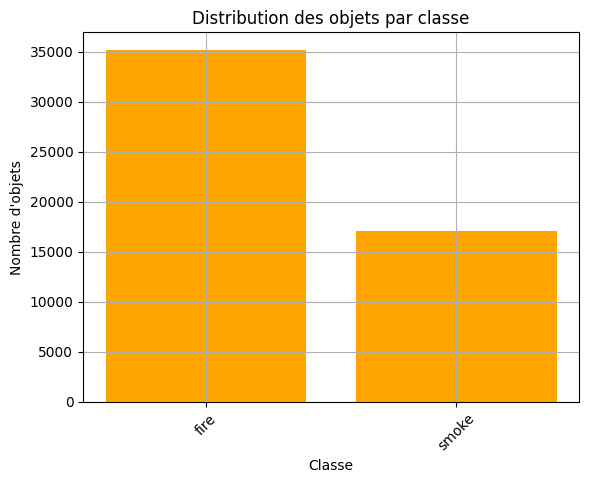

In [7]:
import matplotlib.pyplot as plt

labels = [data_yaml["names"][cls] for cls in class_counter.keys()]
counts = list(class_counter.values())

plt.bar(labels, counts, color='orange')
plt.xlabel("Classe")
plt.ylabel("Nombre d'objets")
plt.title("Distribution des objets par classe")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [8]:
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import shutil

# Dossier d'entrée et sortie
img_dir = dataset.location + "/train/images"
label_dir = dataset.location + "/train/labels"
output_img_dir = dataset.location + "/train/images_aug"
output_label_dir = dataset.location +"/train/labels_aug"

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

# Transformations pour la fumée (classe 1)
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(p=0.3),
    A.Rotate(limit=15, p=0.5),
    A.HueSaturationValue(p=0.3)
])

# Lire tous les fichiers
for filename in os.listdir(label_dir):
    if not filename.endswith(".txt"):
        continue
    label_path = os.path.join(label_dir, filename)
    with open(label_path, "r") as f:
        lines = f.readlines()
        has_smoke = any(line.startswith("1 ") for line in lines)

    if has_smoke:
        # Charger l’image
        img_name = filename.replace(".txt", ".jpg")
        img_path = os.path.join(img_dir, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Erreur lecture : {img_path}")
            continue

        # Appliquer la transformation
        transformed = transform(image=img)
        transformed_img = transformed["image"]

        # Sauvegarder nouvelle image et même label
        out_img_name = f"aug_{img_name}"
        out_label_name = f"aug_{filename}"

        cv2.imwrite(os.path.join(output_img_dir, out_img_name), transformed_img)
        shutil.copy(label_path, os.path.join(output_label_dir, out_label_name))

        print(f" Image augmentée : {out_img_name}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 Image augmentée : aug_3-single_fire_191_jpg.rf.5a31145459b12cd86f55f8b2d040e498.jpg
 Image augmentée : aug_1_mountain_lake_daytime_2240_jpg.rf.76cd13e8d81297cb909636d7d03b95f1.jpg
 Image augmentée : aug_ck0kkg0u65u3q0863z6w2psqp_jpeg_jpg.rf.265cdfd254b15c5cd094cfe10b39cfdc.jpg
 Image augmentée : aug_ck0oulkapr2bj0794zz57fbjp_jpeg_jpg.rf.34a9a653f02a6b601cdb0c287392df82.jpg
 Image augmentée : aug_2_mountain_lake_land_daytime_0400_jpg.rf.90ed157e5f3eb607cdaa1c72304c5a32.jpg
 Image augmentée : aug_1_mountain_lake_night_1580_jpg.rf.4c520035b4f557175945a546a2a39c17.jpg
 Image augmentée : aug_1_mountain_lake_sunset_0100_jpg.rf.d26367f5eecc1c55afcdfe12de9be322.jpg
 Image augmentée : aug_ck0tz2vh7wqqw0721qe4odmlu_jpeg_jpg.rf.43e6e67f66309b9a93e581b29766c1d1.jpg
 Image augmentée : aug_4_snow_night_0280_jpg.rf.bb87c94b3455ecfa69b7a640c419bcfa.jpg
 Image augmentée : aug_2_mountain_lake_land_night_0270_jpg.rf.165ffa30fc

## Fusionne les dossiers augmentés dans les originaux

In [9]:
# Fusionner les images augmentées avec les images originales
!cp /content/wildfire-detection--3/train/images_aug/* /content/wildfire-detection--3/train/images/

# Fusionner les labels augmentés avec les labels originaux
!cp /content/wildfire-detection--3/train/labels_aug/* /content/wildfire-detection--3/train/labels/



In [10]:
from collections import Counter
import glob

label_files = glob.glob(dataset.location + "/train/labels/*.txt")
class_counter = Counter()

for file in label_files:
    with open(file, 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            class_counter[class_id] += 1

# Associer aux noms de classe
for class_id, count in class_counter.items():
    print(f"Classe {data_yaml['names'][class_id]} ({class_id}) : {count} objets")


Classe fire (0) : 51988 objets
Classe smoke (1) : 34246 objets


##Fichiers .txt vides (pas d’annotation)

In [11]:
empty_labels = [file for file in label_files if os.path.getsize(file) == 0]
print(f"{len(empty_labels)} fichiers d’annotations vides")


43 fichiers d’annotations vides


##supprimer les images sans objet

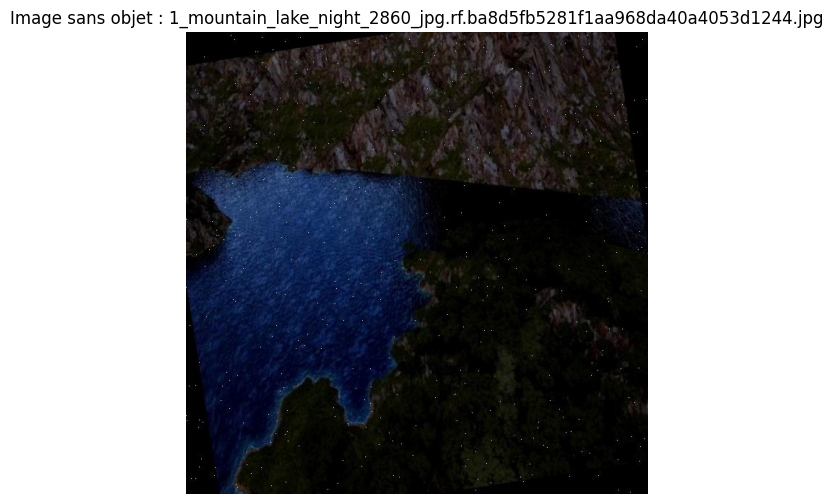

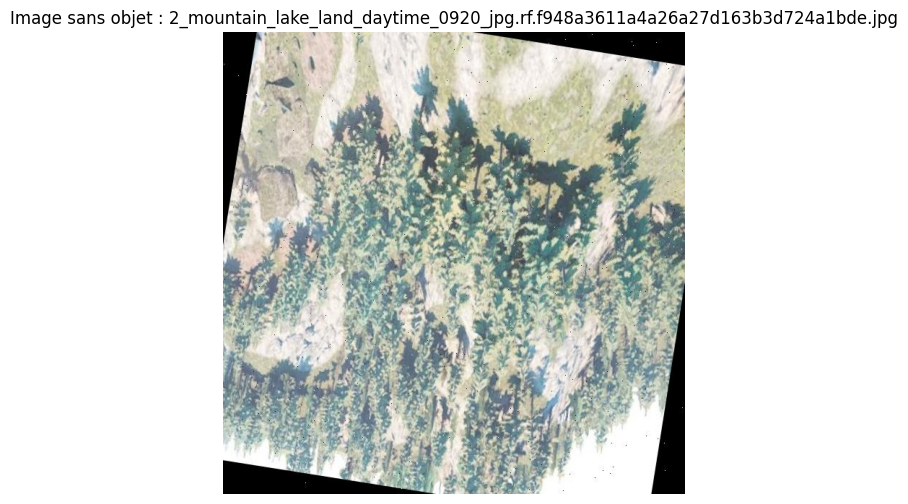

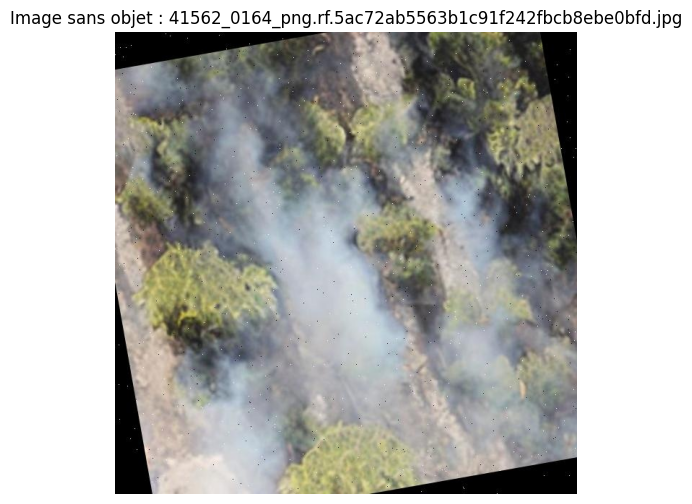

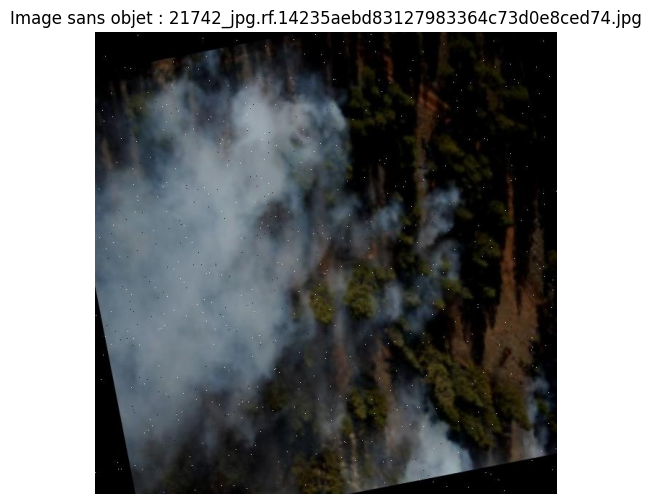

In [12]:
import os
import matplotlib.pyplot as plt
import cv2

# Dossier des labels
labels_dir = dataset.location + "/train/labels"
images_dir = dataset.location + "/train/images"

# 1. Trouver les fichiers labels vides
empty_labels = [f for f in os.listdir(labels_dir) if os.path.getsize(os.path.join(labels_dir, f)) == 0]

# 2. Afficher quelques images correspondantes
for i, label_file in enumerate(empty_labels[:4]):  # Affiche 5 max
    image_file = label_file.replace(".txt", ".jpg")  # adapte si .png
    image_path = os.path.join(images_dir, image_file)

    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Image sans objet : {image_file}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Image non trouvée pour : {image_file}")


In [13]:
import os

# Chemins
labels_dir = dataset.location + "/train/labels"
images_dir = dataset.location + "/train/images"

# Liste des fichiers labels vides
empty_labels = [f for f in os.listdir(labels_dir) if os.path.getsize(os.path.join(labels_dir, f)) == 0]

# Suppression des fichiers vides et leurs images associées
deleted = 0
for label_file in empty_labels:
    label_path = os.path.join(labels_dir, label_file)
    image_name = label_file.replace(".txt", ".jpg")
    image_path = os.path.join(images_dir, image_name)

    # Supprimer fichier .txt
    if os.path.exists(label_path):
        os.remove(label_path)

    # Supprimer image associée
    if os.path.exists(image_path):
        os.remove(image_path)

    deleted += 1

print(f" {deleted} images et fichiers d'annotation vides supprimés.")


 43 images et fichiers d'annotation vides supprimés.


##Visualiser quelques exemples avec bounding boxes  ( les boîtes de détection.)

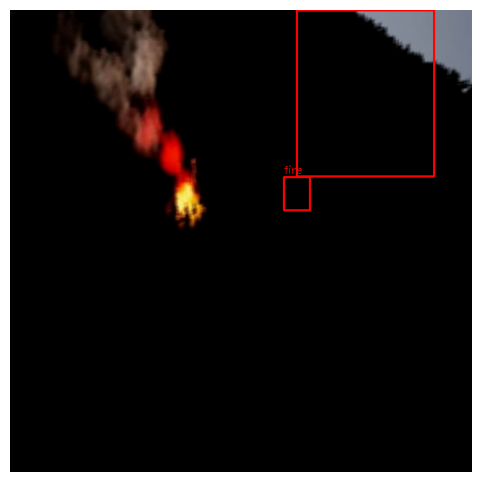

In [15]:
import cv2
import matplotlib.pyplot as plt

def show_image_with_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    with open(label_path, 'r') as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            cx, cy = int(x * w), int(y * h)
            bw, bh = int(bw * w), int(bh * h)
            x1, y1 = cx - bw // 2, cy - bh // 2
            x2, y2 = cx + bw // 2, cy + bh // 2
            cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2)
            cv2.putText(image, data_yaml["names"][int(cls)], (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Exemple
img_name = os.listdir(dataset.location + "/train/images")[10]
show_image_with_boxes(
    dataset.location + "/train/images/" + img_name,
    dataset.location + "/train/labels/" + img_name.replace(".jpg", ".txt")
)


In [16]:
import os

train_img_count = len(os.listdir(dataset.location + "/train/images"))
val_img_count = len(os.listdir(dataset.location + "/valid/images"))
print("Images entraînement :", train_img_count)
print("Images validation :", val_img_count)


Images entraînement : 24288
Images validation : 1215


##Comment détecter le bruit ?  
peux détecter visuellement ou statistiquement le bruit

Méthode simple par variance du pixel
Si la variance locale d'une image est très élevée → il y a probablement du bruit aléatoire (comme le bruit de sel et poivre, ou bruit gaussien).

##appliquer filtre CLAHE + GaussianBlur
🔹 GaussianBlur → pour lisser

🔹 CLAHE → amélioration du contraste (utile pour feu/fumée)

In [17]:
import os
import cv2
import shutil

# 🔧 Paramètres
image_dir = dataset.location + "/train/images"
blur_threshold = 100.0

def is_blurry(image_path, threshold=blur_threshold):
    """Vérifie si une image est floue via la variance du Laplacien"""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return True
    variance = cv2.Laplacian(image, cv2.CV_64F).var()
    return variance < threshold

def enhance_image(image_path):
    """Améliore l’image sans la convertir en niveaux de gris"""
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Appliquer CLAHE séparément sur chaque canal
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)

    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # Appliquer un flou léger sur l’image couleur
    final = cv2.GaussianBlur(img_clahe, (3,3), 0)
    return final

# 📁 Créer un dossier temporaire pour les images améliorées
output_dir = "cleaned_images"
os.makedirs(output_dir, exist_ok=True)


In [18]:
# 🔍 Étape 1 : Détection et traitement
blurry_count = 0
for file in os.listdir(image_dir):
    if not file.lower().endswith((".jpg", ".png")):
        continue
    full_path = os.path.join(image_dir, file)

    if is_blurry(full_path):
        # Image floue → améliorer
        cleaned = enhance_image(full_path)
        if cleaned is not None:
            cv2.imwrite(os.path.join(output_dir, file), cleaned)
            blurry_count += 1

print(f"✅ {blurry_count} images floues ont été détectées et filtrées.")


✅ 4847 images floues ont été détectées et filtrées.


Glyph 128997 (\N{LARGE RED SQUARE}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 128997 (\N{LARGE RED SQUARE}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.


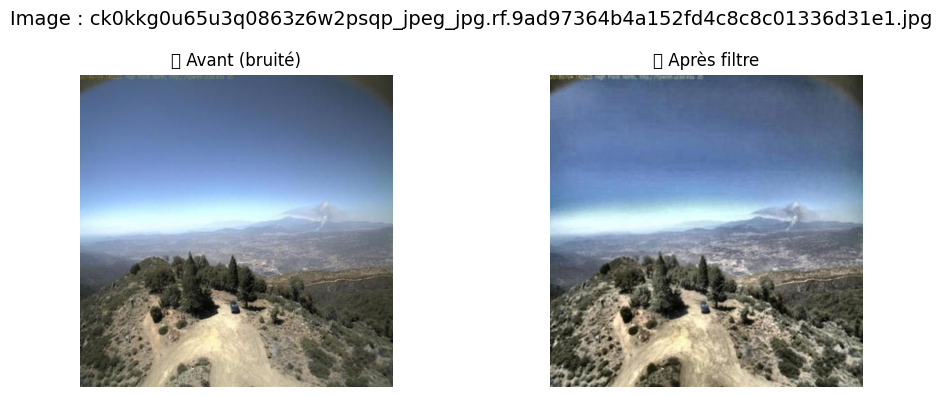

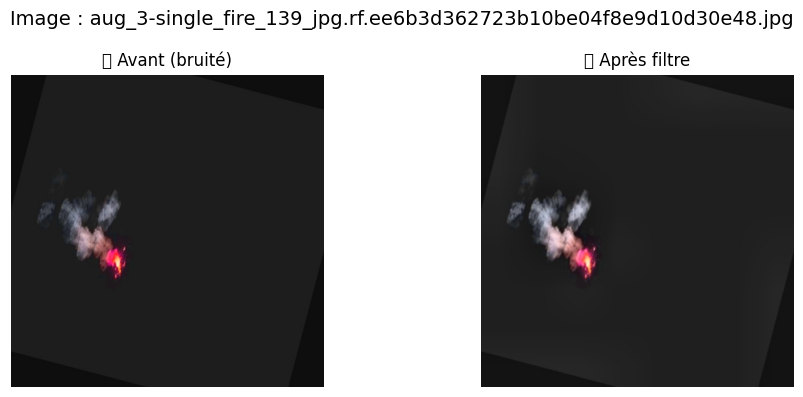

In [19]:
import matplotlib.pyplot as plt

# Comparer les 2 premières images traitées
for file in os.listdir(output_dir)[:2]:
    original_path = os.path.join(image_dir, file)
    filtered_path = os.path.join(output_dir, file)

    # Charger les images
    original = cv2.imread(original_path)
    filtered = cv2.imread(filtered_path)

    if original is None or filtered is None:
        continue

    # Convertir en RGB pour affichage
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)

    # Affichage côte à côte
    plt.figure(figsize=(10, 4))
    plt.suptitle(f"Image : {file}", fontsize=14)
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("🟥 Avant (bruité)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(filtered)
    plt.title("✅ Après filtre")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [20]:
  #  Étape 2 : Remplacer les images originales
replaced = 0
for file in os.listdir(output_dir):
    src = os.path.join(output_dir, file)
    dst = os.path.join(image_dir, file)
    shutil.move(src, dst)
    replaced += 1

print(f" {replaced} images originales ont été remplacées par les versions filtrées.")

#  Étape 3 : Nettoyage final
shutil.rmtree(output_dir)
print(" Nettoyage terminé. Le dossier temporaire a été supprimé.")


 4847 images originales ont été remplacées par les versions filtrées.
 Nettoyage terminé. Le dossier temporaire a été supprimé.


In [21]:
import os
import cv2
import numpy as np
import shutil
import matplotlib.pyplot as plt

# 📁 Répertoire des images
image_dir = dataset.location + "/train/images"
output_dir = "enhanced_images"
trash_dir = "trash_images"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(trash_dir, exist_ok=True)

# 🔧 Seuils ajustables
seuil_sombre = 60         # pixel moyen < 60 = trop sombre
seuil_clair = 200         # pixel moyen > 200 = trop clair
seuil_entropie = 3.0      # entropie < 3 = trop pixelisé

# 🧠 Fonctions de détection

def mean_brightness(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

def image_entropy(img):
    # Convertir l'image couleur en niveaux de gris (1 seule couche d'intensité)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculer l'histogramme des niveaux de gris (256 niveaux de 0 à 255)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

    # Aplatir l'histogramme et le normaliser (somme = 1), pour obtenir une distribution de probabilité
    hist = hist.ravel() / hist.sum()

    # Supprimer les zéros pour éviter log2(0) qui est indéfini
    hist = hist[np.nonzero(hist)]

    # Calculer l'entropie de Shannon : mesure du niveau d'information ou de complexité
    return -np.sum(hist * np.log2(hist))


# 🎨 Corrections

def enhance_dark(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq = cv2.equalizeHist(gray)
    return cv2.cvtColor(eq, cv2.COLOR_GRAY2BGR)

def enhance_bright(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

# 🔁 Boucle de traitement

stats = {'dark': 0, 'bright': 0, 'pixelated': 0, 'normal': 0}
for file in os.listdir(image_dir):
    if not file.lower().endswith((".jpg", ".png")):
        continue

    path = os.path.join(image_dir, file)
    img = cv2.imread(path)
    if img is None:
        continue

    mean = mean_brightness(img)
    ent = image_entropy(img)

    if ent < seuil_entropie:
        shutil.move(path, os.path.join(trash_dir, file))
        stats['pixelated'] += 1
        continue

    if mean < seuil_sombre:
        enhanced = enhance_dark(img)
        stats['dark'] += 1
    elif mean > seuil_clair:
        enhanced = enhance_bright(img)
        stats['bright'] += 1
    else:
        enhanced = img
        stats['normal'] += 1

    cv2.imwrite(os.path.join(output_dir, file), enhanced)

# 🔍 Résumé
print("✅ Nettoyage terminé")
for k, v in stats.items():
    print(f"🔹 {k}: {v} images")

print(f"\n📁 Images corrigées sauvegardées dans : {output_dir}")
print(f"🗑️ Images trop pixelisées déplacées dans : {trash_dir}")


✅ Nettoyage terminé
🔹 dark: 6083 images
🔹 bright: 159 images
🔹 pixelated: 2190 images
🔹 normal: 15856 images

📁 Images corrigées sauvegardées dans : enhanced_images
🗑️ Images trop pixelisées déplacées dans : trash_images


In [22]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")
model.train(data="/content/wildfire-detection--3/data.yaml", epochs=20, imgsz=640)


Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/wildfire-detection--3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

train: Scanning /content/wildfire-detection--3/train/labels... 22098 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22098/22098 [00:24<00:00, 909.99it/s] 

train: /content/wildfire-detection--3/train/images/image_216_jpg.rf.0bbfc066eef25bde47d6f38201544dd4.jpg: 1 duplicate labels removed
train: /content/wildfire-detection--3/train/images/image_216_jpg.rf.35bb254b1af4f2b294620e961f18f34f.jpg: 1 duplicate labels removed
train: /content/wildfire-detection--3/train/images/image_216_jpg.rf.c595c71c7b9c07a57828e52e68453e89.jpg: 1 duplicate labels removed
train: /content/wildfire-detection--3/train/images/image_216_jpg.rf.e9c2b3f96927b130cd12f20cd2500946.jpg: 1 duplicate labels removed


train: New cache created: /content/wildfire-detection--3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 17.3±12.1 MB/s, size: 63.4 KB)


val: Scanning /content/wildfire-detection--3/valid/labels... 1215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1215/1215 [00:02<00:00, 432.23it/s]

val: New cache created: /content/wildfire-detection--3/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.57G      2.084      2.268      1.746         15        640: 100%|██████████| 1382/1382 [07:45<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.52it/s]


                   all       1215       3878      0.618      0.511      0.541       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.36G      2.026      2.072      1.708          3        640: 100%|██████████| 1382/1382 [07:26<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.85it/s]


                   all       1215       3878      0.625      0.515      0.534      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       4.4G      1.979      1.977      1.673         19        640: 100%|██████████| 1382/1382 [07:14<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.89it/s]


                   all       1215       3878      0.677      0.583       0.63      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.45G      1.915      1.883      1.625          6        640: 100%|██████████| 1382/1382 [07:22<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.89it/s]

                   all       1215       3878      0.725      0.586      0.658      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.48G      1.869      1.816      1.596         19        640: 100%|██████████| 1382/1382 [07:15<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.85it/s]


                   all       1215       3878      0.737      0.615      0.695      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.52G       1.83      1.743      1.569          7        640: 100%|██████████| 1382/1382 [07:22<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.86it/s]

                   all       1215       3878      0.765      0.636       0.72      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.52G      1.805       1.69       1.55         92        640:  58%|█████▊    | 796/1382 [04:14<03:31,  2.77it/s]